### **PROYECTO DE CALIDAD DEL AIRE**

  Este proyecto tiene como objetivo predecir si lloverá, la temperatura y los niveles de contaminación del aire
usando datos del IDEAM para Bucaramanga y su área metropolitana. El análisis se desplegará mediante Streamlit.

Estructura del análisis:
1. Importación de Datos
2. Selección de Variables y Filtrado
3. Limpieza
4. Preprocesamiento
5. Análisis Exploratorio de Datos


# **1.Importacion De Datos**
#  -Se traen de un repositorio de git

In [153]:
#Importación del dataset desde repositorio en github
!git clone https://github.com/Santiago-Serrano2004/data-set-ia.git

fatal: destination path 'data-set-ia' already exists and is not an empty directory.


-Se lee el csv

In [154]:
import pandas as pd

df = pd.read_csv('/content/data-set-ia/Reporte_Calidad_de_Aire_AMB_20250319.csv')
print(df.shape)

(16824, 45)


<ipython-input-154-20ce20abb7ad>:3: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/data-set-ia/Reporte_Calidad_de_Aire_AMB_20250319.csv')


-Se importan las librerias necesarias

In [271]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from scipy.stats.mstats import winsorize
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
import pickle
from scipy.stats import trim_mean
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib


# **2. Selección de Variables y Filtrado**

#    -Defino las columnas que quiero mantener, para cumplir el objetivo del proyecto necesaitaremos del tiempo, del sensor PM10 que es un tipo de sensor que mide particulas del aire y es mejor que el sensor PM2.5, tambien mediremos NO2 y O3 y la Temperatura y lluvia, el resto de columnas no nos interesa/sirve para los objetivos.

-se crea la lista keywords donde almacenare los criterios de filtrado o palabras claves para si saber si una columna me sirve o no


-Se calcula la incidencia de las keywords en el df asi identifico cual tiene mas peso o impacto

In [156]:
# Lista de palabras clave
keywords = ['TIEMPO', 'PM10', 'NO2', 'O3', 'TEMPERATURA', 'LLUVIA']

# Contar la cantidad de columnas que contienen cada palabra clave
incidencia = {keyword: sum(keyword in col for col in df.columns) for keyword in keywords}
ans = sum(incidencia.values())

# Mostrar los resultados
print(incidencia)
print("El Total de columnas del nuevo df seria de " + str(ans))


{'TIEMPO': 1, 'PM10': 5, 'NO2': 2, 'O3': 2, 'TEMPERATURA': 5, 'LLUVIA': 5}
El Total de columnas del nuevo df seria de 20


-Se filtra en columnas_filtradas y despue se saca el nuevo df con nuevas dimensiones (20 columnas en lugar de 45)

In [157]:
# Filtrar las columnas que contienen las palabras clave
columnas_filtradas = [col for col in df.columns if any(keyword in col for keyword in keywords)]

# Crear un nuevo DataFrame con solo las columnas filtradas
df_filtrado = df[columnas_filtradas]

# Ver el resultado
print(df_filtrado.shape)
print(df_filtrado.head())

(16824, 20)
             TIEMPO  EST. LAGOS I F/BLANCA PM10  EST. LAGOS I F/BLANCA NO2  \
0  01/10/2018 00:00                         NaN                        NaN   
1  01/10/2018 01:00                         NaN                        NaN   
2  01/10/2018 02:00                         NaN                        NaN   
3  01/10/2018 03:00                         NaN                        NaN   
4  01/10/2018 04:00                         NaN                        NaN   

   EST. LAGOS I F/BLANCA O3  EST. LACIUDADELA PM10  EST. LACIUDADELA NO2  \
0                       NaN                   23.8               23.8128   
1                       NaN                   14.6                1.2628   
2                       NaN                   14.5               12.6280   
3                       NaN                   16.6               13.3496   
4                       NaN                   18.3                8.4788   

   EST. LACIUDADELA O3  EST. SANTA CRUZ GIRÓN PM10  EST. SAN F

-se crea la estructura de datos estaciones_unicas ( lista)  donde se guarda el nombre de la estacion sin importar que se repita con el sensor, es decir EST. LACIUDADELA PM10 y EST. LACIUDADELA NO2 ,lo guardara como una sola estacion EST. LACIUDADELA en la lista

In [159]:
# Lista de palabras clave
keywords = ['PM10', 'NO2', 'O3', 'TEMPERATURA', 'LLUVIA']

# Conjunto para almacenar los nombres únicos de las estaciones

estaciones_unicas = set() #usar el set me asegura guardar tanto EST. LACIUDADELA PM10 como EST. LACIUDADELA TEMPERATURA sin hacer duplicados

# Extraer los nombres de las estaciones asegurándonos de que comiencen con "EST. "
for col in df.columns:
    if col.startswith("EST. "):  # Filtramos solo estaciones reales
        for keyword in keywords:
            if keyword in col:
                nombre_estacion = re.sub(rf'\s{keyword}.*$', '', col)  # Elimina la keyword al final
                estaciones_unicas.add(nombre_estacion)

# Convertir el conjunto a una lista ordenada
estaciones_unicas = sorted(estaciones_unicas)

# Mostrar el resultado
print("Estaciones únicas:", estaciones_unicas)
print("Cantidad de estaciones:", len(estaciones_unicas))


Estaciones únicas: ['EST. LACIUDADELA', 'EST. LAGOS DEL CACIQUE', 'EST. LAGOS I F/BLANCA', 'EST. SAN FRANCISCO', 'EST. SANTA CRUZ GIRÓN']
Cantidad de estaciones: 5


Se hace el relacionamiento estacion ->  sensor para poder saber que sensores hay por estacion, por lo que se crea un diccionario que tiene de llave cada estacion presente en estaciones_unicas y se mira con que sensores sale acompañado en el df presente en keywords y por lo que el valor de cada llave sera una lista que contiene el nombre de los sensores que tiene esa estacion

In [160]:
# Lista de sensores de interés
keywords = ["PM10", "NO2", "O3", "TEMPERATURA", "LLUVIA"]

# Diccionario que asocia cada estación con su lista de sensores
distribucion = defaultdict(set)  # Usamos set() para evitar duplicados

# Recorrer las columnas del DataFrame
for col in df.columns:
    if col.startswith("EST. "):  # Filtramos solo las estaciones
        partes = col.split()  # Dividimos la columna por espacios
        estacion = " ".join(partes[:-1])  # Tomamos todo menos la última palabra como estación
        sensor = partes[-1]  # La última palabra es el sensor

        if sensor in keywords:  # Solo añadimos sensores de interés
            distribucion[estacion].add(sensor)

# Convertir los sets a listas para que la salida sea más clara
distribucion = {estacion: list(sensores) for estacion, sensores in distribucion.items()}

print(distribucion)


{'EST. LAGOS I F/BLANCA': ['NO2', 'LLUVIA', 'PM10', 'O3', 'TEMPERATURA'], 'EST. LACIUDADELA': ['NO2', 'LLUVIA', 'PM10', 'O3', 'TEMPERATURA'], 'EST. SANTA CRUZ GIRÓN': ['LLUVIA', 'PM10', 'TEMPERATURA'], 'EST. SAN FRANCISCO': ['LLUVIA', 'PM10', 'TEMPERATURA'], 'EST. LAGOS DEL CACIQUE': ['LLUVIA', 'PM10', 'TEMPERATURA']}


Se revisa que tipo de datos estan en las columans del df

In [161]:
print(df_filtrado.dtypes)


TIEMPO                                 object
EST. LAGOS I F/BLANCA PM10            float64
EST. LAGOS I F/BLANCA NO2             float64
EST. LAGOS I F/BLANCA O3              float64
EST. LACIUDADELA PM10                 float64
EST. LACIUDADELA NO2                  float64
EST. LACIUDADELA O3                   float64
EST. SANTA CRUZ GIRÓN PM10            float64
EST. SAN FRANCISCO PM10               float64
EST. LAGOS DEL CACIQUE PM10           float64
EST. LAGOS I F/BLANCA TEMPERATURA     float64
EST. LAGOS I F/BLANCA LLUVIA          float64
EST. LACIUDADELA TEMPERATURA          float64
EST. LACIUDADELA LLUVIA               float64
EST. SANTA CRUZ GIRÓN TEMPERATURA     float64
EST. SANTA CRUZ GIRÓN LLUVIA          float64
EST. SAN FRANCISCO TEMPERATURA        float64
EST. SAN FRANCISCO LLUVIA             float64
EST. LAGOS DEL CACIQUE TEMPERATURA    float64
EST. LAGOS DEL CACIQUE LLUVIA         float64
dtype: object


-Se agrega la columna FECHA y HORA para ir ajustando el df para empezar a trabajar

In [162]:
# Verificar si la columna TIEMPO es de tipo object
if df_filtrado["TIEMPO"].dtype == "object":
    # Crear la columna FECHA tomando los primeros caracteres antes de los últimos 5
    df_filtrado["FECHA"] = df_filtrado["TIEMPO"].str[:-6]

    # Crear la columna HORA tomando los últimos 5 caracteres
    df_filtrado["HORA"] = df_filtrado["TIEMPO"].str[-5:]

# Verificar resultados
print(df_filtrado[["TIEMPO", "FECHA", "HORA"]].head())


             TIEMPO       FECHA   HORA
0  01/10/2018 00:00  01/10/2018  00:00
1  01/10/2018 01:00  01/10/2018  01:00
2  01/10/2018 02:00  01/10/2018  02:00
3  01/10/2018 03:00  01/10/2018  03:00
4  01/10/2018 04:00  01/10/2018  04:00


<ipython-input-162-6aa367cc0a2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["FECHA"] = df_filtrado["TIEMPO"].str[:-6]
<ipython-input-162-6aa367cc0a2b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["HORA"] = df_filtrado["TIEMPO"].str[-5:]


-Se comprueba el nuevo dimensionamiento del df y de que tipo son mis variables

In [163]:
print(df_filtrado.shape)
print(df_filtrado.dtypes)

(16824, 22)
TIEMPO                                 object
EST. LAGOS I F/BLANCA PM10            float64
EST. LAGOS I F/BLANCA NO2             float64
EST. LAGOS I F/BLANCA O3              float64
EST. LACIUDADELA PM10                 float64
EST. LACIUDADELA NO2                  float64
EST. LACIUDADELA O3                   float64
EST. SANTA CRUZ GIRÓN PM10            float64
EST. SAN FRANCISCO PM10               float64
EST. LAGOS DEL CACIQUE PM10           float64
EST. LAGOS I F/BLANCA TEMPERATURA     float64
EST. LAGOS I F/BLANCA LLUVIA          float64
EST. LACIUDADELA TEMPERATURA          float64
EST. LACIUDADELA LLUVIA               float64
EST. SANTA CRUZ GIRÓN TEMPERATURA     float64
EST. SANTA CRUZ GIRÓN LLUVIA          float64
EST. SAN FRANCISCO TEMPERATURA        float64
EST. SAN FRANCISCO LLUVIA             float64
EST. LAGOS DEL CACIQUE TEMPERATURA    float64
EST. LAGOS DEL CACIQUE LLUVIA         float64
FECHA                                  object
HORA                  


# **3.Limpieza**
##  -Se hace todo el tratamiento de variables nulas


-Se calculan el numero de nulos por columna

In [164]:
df_filtrado.isnull().sum()


TIEMPO                                   0
EST. LAGOS I F/BLANCA PM10            6093
EST. LAGOS I F/BLANCA NO2             7105
EST. LAGOS I F/BLANCA O3              6991
EST. LACIUDADELA PM10                 4295
EST. LACIUDADELA NO2                  5009
EST. LACIUDADELA O3                   3688
EST. SANTA CRUZ GIRÓN PM10            2069
EST. SAN FRANCISCO PM10                964
EST. LAGOS DEL CACIQUE PM10           3540
EST. LAGOS I F/BLANCA TEMPERATURA     3011
EST. LAGOS I F/BLANCA LLUVIA          3009
EST. LACIUDADELA TEMPERATURA           869
EST. LACIUDADELA LLUVIA                845
EST. SANTA CRUZ GIRÓN TEMPERATURA      194
EST. SANTA CRUZ GIRÓN LLUVIA           193
EST. SAN FRANCISCO TEMPERATURA         984
EST. SAN FRANCISCO LLUVIA              989
EST. LAGOS DEL CACIQUE TEMPERATURA    1864
EST. LAGOS DEL CACIQUE LLUVIA          845
FECHA                                    0
HORA                                     0
dtype: int64

-Graficamos Para reconocer cuales son las variables mas afectadas por los nulos

(16824, 22)

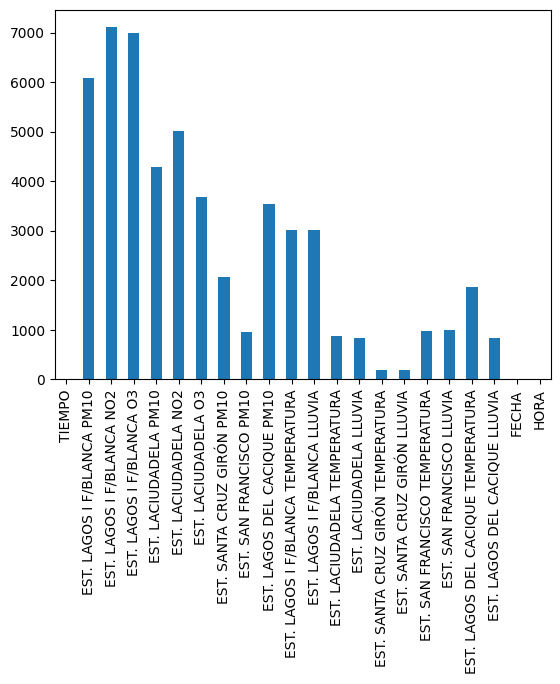

In [165]:
df_filtrado.isnull().sum().plot(kind="bar")
df_filtrado.shape



EST. LAGOS I F/BLANCA PM10            21.339823
EST. LAGOS I F/BLANCA NO2             11.504645
EST. LAGOS I F/BLANCA O3              26.155675
EST. LACIUDADELA PM10                 16.695449
EST. LACIUDADELA NO2                  11.438856
EST. LACIUDADELA O3                   25.112871
EST. SANTA CRUZ GIRÓN PM10            26.070695
EST. SAN FRANCISCO PM10               17.892072
EST. LAGOS DEL CACIQUE PM10           21.728737
EST. LAGOS I F/BLANCA TEMPERATURA      3.253602
EST. LAGOS I F/BLANCA LLUVIA           0.599432
EST. LACIUDADELA TEMPERATURA           3.649415
EST. LACIUDADELA LLUVIA                0.644266
EST. SANTA CRUZ GIRÓN TEMPERATURA      3.671549
EST. SANTA CRUZ GIRÓN LLUVIA           0.361830
EST. SAN FRANCISCO TEMPERATURA         2.363264
EST. SAN FRANCISCO LLUVIA              1.181138
EST. LAGOS DEL CACIQUE TEMPERATURA     4.388610
EST. LAGOS DEL CACIQUE LLUVIA          0.767404
dtype: float64


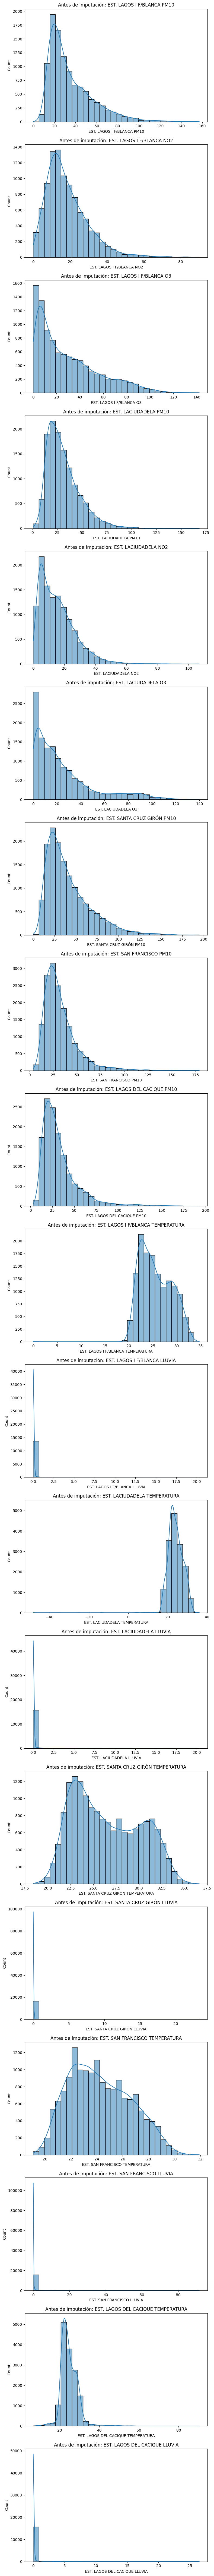

In [166]:
# Filtrar columnas que contengan alguna de las estaciones en su nombre
columnas_filtradas = [col for col in df_filtrado.columns if any(est in col for est in estaciones_unicas)]

print(df_filtrado[columnas_filtradas].std())

# Crear gráficos antes de la imputación
fig, axes = plt.subplots(len(columnas_filtradas), 1, figsize=(8, 5 * len(columnas_filtradas)))

for i, col in enumerate(columnas_filtradas):
    sns.histplot(df_filtrado[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Antes de imputación: {col}")

plt.tight_layout()
plt.show()


In [167]:
# Filtrar solo columnas numéricas o las que empiezan con "EST. "
columnas_sensores = [col for col in df_filtrado.columns if df_filtrado[col].dtype == "float64" or col.startswith("EST.")]

# Crear DataFrame de comparación
comparacion = pd.DataFrame({
    "Media": df_filtrado[columnas_sensores].mean(),
    "Mediana": df_filtrado[columnas_sensores].median(),
    "Diferencia": df_filtrado[columnas_sensores].mean() - df_filtrado[columnas_sensores].median()
})

# Mostrar resultados
print(comparacion)


                                        Media  Mediana  Diferencia
EST. LAGOS I F/BLANCA PM10          35.271000  28.3000    6.971000
EST. LAGOS I F/BLANCA NO2           18.265393  15.6948    2.570593
EST. LAGOS I F/BLANCA O3            29.403584  21.7000    7.703584
EST. LACIUDADELA PM10               31.158393  27.4000    3.758393
EST. LACIUDADELA NO2                15.472426  13.1692    2.303226
EST. LACIUDADELA O3                 24.559988  16.7000    7.859988
EST. SANTA CRUZ GIRÓN PM10          41.342542  34.1000    7.242542
EST. SAN FRANCISCO PM10             32.542144  28.2000    4.342144
EST. LAGOS DEL CACIQUE PM10         33.246630  27.3000    5.946630
EST. LAGOS I F/BLANCA TEMPERATURA   25.595410  25.1000    0.495410
EST. LAGOS I F/BLANCA LLUVIA         0.052870   0.0000    0.052870
EST. LACIUDADELA TEMPERATURA        24.148455  23.8000    0.348455
EST. LACIUDADELA LLUVIA              0.068521   0.0000    0.068521
EST. SANTA CRUZ GIRÓN TEMPERATURA   26.443151  25.8000    0.64

Tratamiento de Valores Nulos:

Nulos Naturales vs. Nulos Reales


Al analizar los datos de calidad del aire, observamos que algunas estaciones y sensores comenzaron a reportar datos en diferentes momentos. Esto significa que hay periodos donde ciertos sensores aún no existían o no estaban en funcionamiento, lo que genera valores nulos que no representan datos perdidos, sino ausencia de medición en ese periodo.

Para un mejor tratamiento de los datos, clasificamos los valores nulos en dos categorías:

🔹 Nulos Naturales:

Son aquellos que aparecen antes de que un sensor haya comenzado a reportar datos.

No deben ser imputados ni interpretados como datos faltantes.

Se deben ignorar en el proceso de imputación.

🔹 Nulos Reales:

Son aquellos que aparecen dentro del periodo en el que un sensor ya estaba en funcionamiento.

Representan datos faltantes debido a fallos en la medición o transmisión de datos.

Sí deben ser imputados con técnicas estadísticas adecuadas.



In [168]:


# Convertir la columna FECHA a datetime correctamente
df_filtrado["FECHA"] = pd.to_datetime(df_filtrado["FECHA"], errors="coerce", dayfirst=True)

# Diccionario para almacenar el rango de vida de cada sensor
rango_vida_sensores = {}

# Iterar sobre cada sensor (columna) en el DataFrame, ignorando 'FECHA' y 'HORA'
for sensor in df_filtrado.columns:
    if sensor not in ["FECHA", "HORA", "TIEMPO"]:
        # Filtrar solo filas donde el sensor tenga un valor válido (no nulo)
        datos_sensor = df_filtrado[["FECHA", sensor]].dropna(subset=[sensor])

        if not datos_sensor.empty:  # Verificar si hay datos válidos
            fecha_inicio = datos_sensor["FECHA"].min()  # Primera fecha con dato válido
            fecha_fin = datos_sensor["FECHA"].max()    # Última fecha con dato válido

            rango_vida_sensores[sensor] = (fecha_inicio, fecha_fin)

# Convertir a DataFrame para mejor visualización
df_rango_vida = pd.DataFrame.from_dict(rango_vida_sensores, orient="index", columns=["Inicio", "Fin"]).reset_index()
df_rango_vida.rename(columns={"index": "Sensor"}, inplace=True)

# 🔹 Imprimir para revisar si las fechas están correctas
print(df_rango_vida.head(100))



                                Sensor     Inicio        Fin
0           EST. LAGOS I F/BLANCA PM10 2018-10-05 2020-05-01
1            EST. LAGOS I F/BLANCA NO2 2018-10-05 2020-05-01
2             EST. LAGOS I F/BLANCA O3 2018-10-05 2020-05-01
3                EST. LACIUDADELA PM10 2018-10-01 2020-08-31
4                 EST. LACIUDADELA NO2 2018-10-01 2020-08-31
5                  EST. LACIUDADELA O3 2018-10-01 2020-06-15
6           EST. SANTA CRUZ GIRÓN PM10 2018-10-01 2020-08-31
7              EST. SAN FRANCISCO PM10 2018-10-01 2020-08-31
8          EST. LAGOS DEL CACIQUE PM10 2018-10-01 2020-07-06
9    EST. LAGOS I F/BLANCA TEMPERATURA 2018-10-01 2020-05-01
10        EST. LAGOS I F/BLANCA LLUVIA 2018-10-03 2020-05-01
11        EST. LACIUDADELA TEMPERATURA 2018-10-03 2020-08-31
12             EST. LACIUDADELA LLUVIA 2018-10-03 2020-08-31
13   EST. SANTA CRUZ GIRÓN TEMPERATURA 2018-10-01 2020-08-31
14        EST. SANTA CRUZ GIRÓN LLUVIA 2018-10-01 2020-08-31
15      EST. SAN FRANCIS

<ipython-input-168-94d85dec265f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["FECHA"] = pd.to_datetime(df_filtrado["FECHA"], errors="coerce", dayfirst=True)


<ipython-input-169-f3f93911e4f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["FECHA"] = pd.to_datetime(df_filtrado["FECHA"], errors="coerce", dayfirst=True)


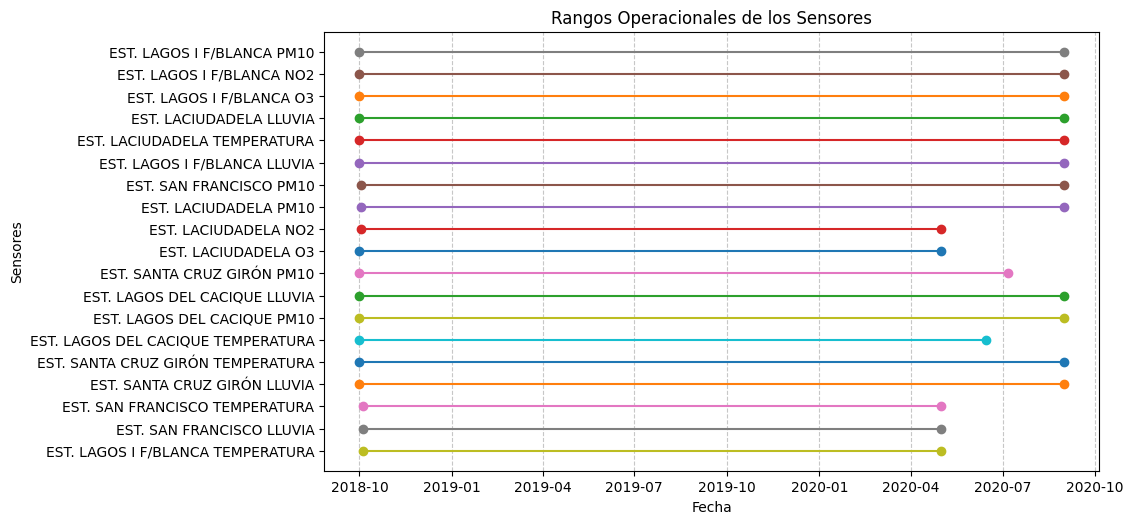

In [169]:
# Convertir la columna FECHA a datetime correctamente
df_filtrado["FECHA"] = pd.to_datetime(df_filtrado["FECHA"], errors="coerce", dayfirst=True)

# Diccionario para almacenar el rango de vida de cada sensor
rango_vida_sensores = {}

# Iterar sobre cada sensor (columna) en el DataFrame, ignorando 'FECHA' y 'HORA'
for sensor in df_filtrado.columns:
    if sensor not in ["FECHA", "HORA", "TIEMPO"]:
        # Filtrar solo filas donde el sensor tenga un valor válido (no nulo)
        datos_sensor = df_filtrado[["FECHA", sensor]].dropna(subset=[sensor])

        if not datos_sensor.empty:  # Verificar si hay datos válidos
            fecha_inicio = datos_sensor.iloc[0]["FECHA"]  # Primera fecha con dato válido
            fecha_fin = datos_sensor.iloc[-1]["FECHA"]  # Última fecha con dato válido

            rango_vida_sensores[sensor] = (fecha_inicio, fecha_fin)

# Convertir a DataFrame para mejor visualización
df_rango_vida = pd.DataFrame.from_dict(rango_vida_sensores, orient="index", columns=["Inicio", "Fin"]).reset_index()
df_rango_vida.rename(columns={"index": "Sensor"}, inplace=True)

# Ordenar por fecha de inicio para mejorar la visualización
df_rango_vida = df_rango_vida.sort_values(by="Inicio")

# Crear la figura del gráfico
plt.figure(figsize=(10, len(df_rango_vida) * 0.3))  # Ajustar tamaño según cantidad de sensores

# Graficar cada sensor como una barra horizontal
for i, row in df_rango_vida.iterrows():
    plt.plot([row["Inicio"], row["Fin"]], [i, i], marker="o", label=row["Sensor"])

# Configurar el eje Y con los nombres de los sensores
plt.yticks(range(len(df_rango_vida)), df_rango_vida["Sensor"])
plt.xlabel("Fecha")
plt.ylabel("Sensores")
plt.title("Rangos Operacionales de los Sensores")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Mostrar la gráfica



Aunque la gráfica no lo muestre con total claridad, gracias a la tabla anterior puedo identificar las fechas de inicio de cada sensor y su rango operacional dentro del dataset. Esto me permite tomar mejores decisiones sobre cómo manejar los valores nulos naturales. Por ejemplo, dado que todos los sensores comienzan a operar alrededor de octubre, es evidente que los primeros 10 meses contienen nulos debido a la ausencia de registros y no por fallos en la captura de datos."

En este paso, buscamos restringir aún más los datos eliminando los registros con nulos naturales de manera más agresiva. Para ello, en lugar de usar percentiles, aplicamos una estrategia basada en la mediana de las fechas únicas de inicio y fin de los sensores.

🔹 ¿Por qué elegir la mediana?
Evita que el rango sea demasiado amplio (como en el percentil 25-75).

Se mantiene un balance entre eliminar nulos y conservar datos útiles.

Representa mejor el comportamiento real de los sensores.

🔹 ¿Cómo se aplica el filtro?
Se extraen todas las fechas únicas de inicio y fin de operación de los sensores.

Se ordenan y se toma la fecha central (mediana) como nuevo punto de corte.

Se eliminan los registros fuera de este rango.

Se verifica si hay filas donde todos los sensores sean nulos después del filtrado.

Este enfoque nos ayuda a reducir los nulos naturales sin afectar en exceso la información disponible.









In [170]:
# Crear una copia del DataFrame original para seguridad
df_ajustado = df_filtrado.copy()

# Convertir la columna FECHA a datetime (por seguridad)
df_ajustado["FECHA"] = pd.to_datetime(df_ajustado["FECHA"], errors="coerce", dayfirst=True)

# Obtener fechas únicas de inicio y fin de los sensores
fechas_inicio_unicas = sorted(df_rango_vida["Inicio"].unique())
fechas_fin_unicas = sorted(df_rango_vida["Fin"].unique())

# Seleccionar la mediana de cada lista como punto medio
fecha_inicio_restringida = fechas_inicio_unicas[len(fechas_inicio_unicas) // 2]
fecha_fin_restringida = fechas_fin_unicas[len(fechas_fin_unicas) // 2]

# Filtrar el DataFrame dentro del nuevo rango más restringido
df_ajustado = df_ajustado[
    (df_ajustado["FECHA"] >= fecha_inicio_restringida) & (df_ajustado["FECHA"] <= fecha_fin_restringida)
]

# Verificar si hay filas donde todos los sensores sean nulos
sensores_cols = [col for col in df_ajustado.columns if col not in ["FECHA", "HORA", "TIEMPO"]]
filas_todas_nulas = df_ajustado[sensores_cols].isna().all(axis=1).sum()

# Mostrar mensaje si hay filas completamente nulas
if filas_todas_nulas > 0:
    print(f"⚠️ Advertencia: Hay {filas_todas_nulas} filas donde todos los sensores tienen valores nulos después del filtrado.")

# Mostrar las primeras filas del DataFrame ajustado
print(df_ajustado.head())



              TIEMPO  EST. LAGOS I F/BLANCA PM10  EST. LAGOS I F/BLANCA NO2  \
48  03/10/2018 00:00                         NaN                        NaN   
49  03/10/2018 01:00                         NaN                        NaN   
50  03/10/2018 02:00                         NaN                        NaN   
51  03/10/2018 03:00                         NaN                        NaN   
52  03/10/2018 04:00                         NaN                        NaN   

    EST. LAGOS I F/BLANCA O3  EST. LACIUDADELA PM10  EST. LACIUDADELA NO2  \
48                       NaN                   26.2               18.2204   
49                       NaN                   22.8               13.7104   
50                       NaN                   14.2                0.7216   
51                       NaN                   12.4                   NaN   
52                       NaN                   13.5                3.9688   

    EST. LACIUDADELA O3  EST. SANTA CRUZ GIRÓN PM10  EST. SAN 

In [171]:
df_ajustado.shape

(15392, 22)

In [99]:
# Filtrar columnas que contengan alguna de las estaciones en su nombre
columnas_filtradas = [col for col in df_filtrado.columns if any(est in col for est in estaciones_unicas)]

# Calcular desviación estándar antes y después
print("Desviación estándar antes del ajuste:")
print(df_filtrado[columnas_filtradas].std())

print("\nDesviación estándar después del ajuste:")
print(df_ajustado[columnas_filtradas].std())



Desviación estándar antes del ajuste:
EST. LAGOS I F/BLANCA PM10            21.339823
EST. LAGOS I F/BLANCA NO2             11.504645
EST. LAGOS I F/BLANCA O3              26.155675
EST. LACIUDADELA PM10                 16.695449
EST. LACIUDADELA NO2                  11.438856
EST. LACIUDADELA O3                   25.112871
EST. SANTA CRUZ GIRÓN PM10            26.070695
EST. SAN FRANCISCO PM10               17.892072
EST. LAGOS DEL CACIQUE PM10           21.728737
EST. LAGOS I F/BLANCA TEMPERATURA      3.253602
EST. LAGOS I F/BLANCA LLUVIA           0.599432
EST. LACIUDADELA TEMPERATURA           3.649415
EST. LACIUDADELA LLUVIA                0.644266
EST. SANTA CRUZ GIRÓN TEMPERATURA      3.671549
EST. SANTA CRUZ GIRÓN LLUVIA           0.361830
EST. SAN FRANCISCO TEMPERATURA         2.363264
EST. SAN FRANCISCO LLUVIA              1.181138
EST. LAGOS DEL CACIQUE TEMPERATURA     4.388610
EST. LAGOS DEL CACIQUE LLUVIA          0.767404
dtype: float64

Desviación estándar después del aj

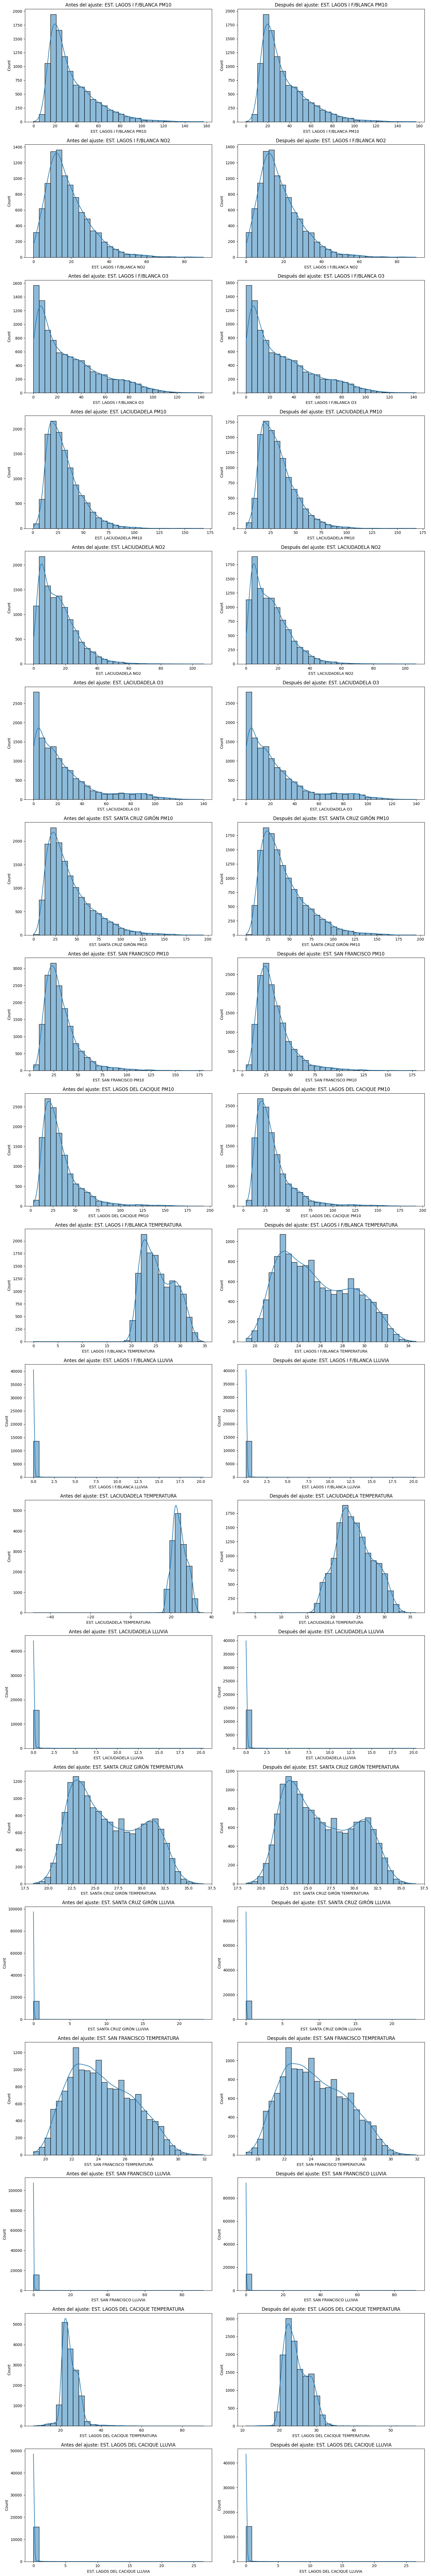

In [172]:
# Crear gráficos antes y después de la imputación
fig, axes = plt.subplots(len(columnas_filtradas), 2, figsize=(16, 5 * len(columnas_filtradas)))

for i, col in enumerate(columnas_filtradas):
    # Gráfico antes del ajuste
    sns.histplot(df_filtrado[col], kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Antes del ajuste: {col}")

    # Gráfico después del ajuste
    sns.histplot(df_ajustado[col], kde=True, bins=30, ax=axes[i, 1])
    axes[i, 1].set_title(f"Después del ajuste: {col}")

plt.tight_layout()
plt.show()

<Axes: >

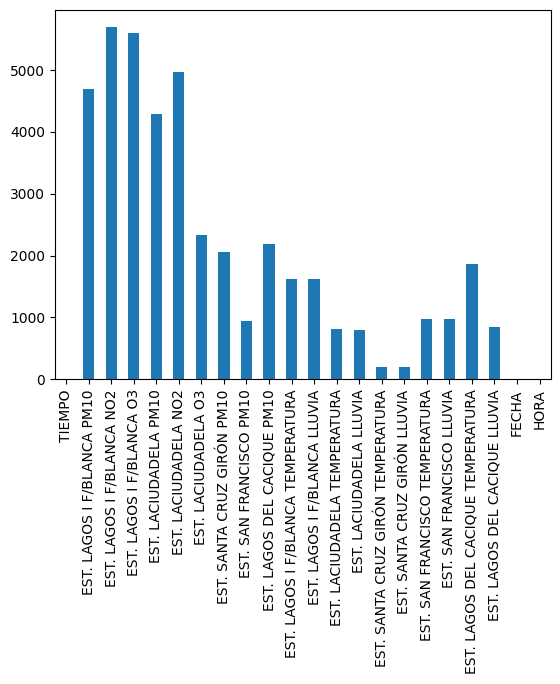

In [173]:
df_ajustado.isnull().sum().plot(kind="bar")

## Tratamiento de valores nulos reales: normales vs. atípicos**

Después de eliminar los nulos naturales, es decir, aquellos registros completamente vacíos o sin información útil, el siguiente paso es tratar los valores nulos restantes. Estos se pueden clasificar en dos tipos principales: nulos normales y nulos atípicos, cada uno con características y soluciones específicas.

### **Diferenciando los tipos de valores nulos**


**Nulos normales**: Son valores ausentes que aparecen dentro del rango válido de fechas y en sensores que, en general, registran datos coherentes. Estos nulos pueden deberse a fallos momentáneos en la transmisión de datos, mantenimientos o pequeñas interrupciones en la medición.


**Solución:** Se imputarán con la media de la columna dentro del rango válido, ya que este método preserva la tendencia general de los datos sin introducir sesgos significativos.


**Nulos atípicos**: Son valores ausentes que se encuentran en registros donde hay otros indicios de problemas en la medición, como valores extremadamente altos o bajos que no tienen sentido en el contexto. Estos pueden ser consecuencia de fallos en los sensores, errores en la transmisión o condiciones anómalas.


**Solución**: Para evitar que estos errores distorsionen el análisis, estos nulos se imputarán con la mediana, ya que este estadístico es más robusto frente a valores extremos y permite obtener una representación más estable de los datos.

Este enfoque nos permitirá completar los datos de manera adecuada sin introducir sesgos innecesarios. A continuación, se implementará el código para realizar este tratamiento.

In [174]:
# Definimos los rangos aceptables para cada sensor basado en valores razonables y referencias
rangos_sensores = {
    'EST. LAGOS I F/BLANCA TEMPERATURA': (18, 44),
    'EST. LACIUDADELA TEMPERATURA': (18, 44),
    'EST. SANTA CRUZ GIRÓN TEMPERATURA': (18, 44),
    'EST. SAN FRANCISCO TEMPERATURA': (18, 44),
    'EST. LAGOS DEL CACIQUE TEMPERATURA': (18, 44),

    'EST. LAGOS I F/BLANCA PM10': (0, 150),  # Límites basados en estándares de calidad del aire
    'EST. LACIUDADELA PM10': (0, 150),
    'EST. SANTA CRUZ GIRÓN PM10': (0, 150),
    'EST. SAN FRANCISCO PM10': (0, 150),
    'EST. LAGOS DEL CACIQUE PM10': (0, 150),

    'EST. LAGOS I F/BLANCA NO2': (0, 200),  # Promedios típicos y máximos en zonas urbanas
    'EST. LACIUDADELA NO2': (0, 200),

    'EST. LAGOS I F/BLANCA O3': (0, 180),  # Valores típicos de ozono en ppm
    'EST. LACIUDADELA O3': (0, 180),
}

# Creamos una copia del DataFrame para trabajar sobre ella
df_normalizado = df_ajustado.copy()



In [175]:
# Excluir las columnas de lluvia del tratamiento
sensores_filtrados = [sensor for sensor in rangos_sensores.keys() if "LLUVIA" not in sensor]

# Identificamos valores fuera de los rangos definidos
outliers_mask = pd.DataFrame(False, index=df_normalizado.index, columns=df_normalizado.columns)

for sensor in sensores_filtrados:
    min_val, max_val = rangos_sensores[sensor]
    outliers_mask[sensor] = (df_normalizado[sensor] < min_val) | (df_normalizado[sensor] > max_val)

# Ahora, por cada outlier detectado, agrupamos con sus vecinos más cercanos
for sensor in sensores_filtrados:
    outlier_indices = outliers_mask[outliers_mask[sensor]].index  # Filtramos las filas con outliers

    for idx in outlier_indices:
        start_idx = max(idx - 5, 0)  # Evita índices negativos
        end_idx = min(idx + 5, len(df_normalizado) - 1)  # Evita índices fuera de rango

        # Extraemos los datos cercanos a la anomalía
        surrounding_values = df_normalizado.loc[start_idx:end_idx, sensor]

        # Si hay valores nulos dentro de ese rango, imputamos con la mediana de la columna
        if surrounding_values.isnull().any():
            df_normalizado.loc[idx, sensor] = df_normalizado[sensor].median()


In [176]:
# Validar que no queden valores fuera de los rangos establecidos
for sensor, (min_val, max_val) in rangos_sensores.items():
    fuera_de_rango = df_normalizado[(df_normalizado[sensor] < min_val) | (df_normalizado[sensor] > max_val)]
    if not fuera_de_rango.empty:
        print(f"Advertencia: Aún hay valores fuera de rango en {sensor}")
    else:
        print(f"Validación exitosa: No hay valores fuera de rango en {sensor}")

# Validar que los valores nulos atípicos fueron imputados correctamente
nulos_despues = df_normalizado.isnull().sum()
nulos_atipicos_despues = nulos_despues[nulos_despues > 0]

if nulos_atipicos_despues.empty:
    print("Validación exitosa: No hay nulos atípicos restantes.")
else:
    print("Advertencia: Aún hay nulos atípicos sin imputar.")
    print(nulos_atipicos_despues)



Validación exitosa: No hay valores fuera de rango en EST. LAGOS I F/BLANCA TEMPERATURA
Advertencia: Aún hay valores fuera de rango en EST. LACIUDADELA TEMPERATURA
Validación exitosa: No hay valores fuera de rango en EST. SANTA CRUZ GIRÓN TEMPERATURA
Validación exitosa: No hay valores fuera de rango en EST. SAN FRANCISCO TEMPERATURA
Advertencia: Aún hay valores fuera de rango en EST. LAGOS DEL CACIQUE TEMPERATURA
Advertencia: Aún hay valores fuera de rango en EST. LAGOS I F/BLANCA PM10
Advertencia: Aún hay valores fuera de rango en EST. LACIUDADELA PM10
Advertencia: Aún hay valores fuera de rango en EST. SANTA CRUZ GIRÓN PM10
Advertencia: Aún hay valores fuera de rango en EST. SAN FRANCISCO PM10
Advertencia: Aún hay valores fuera de rango en EST. LAGOS DEL CACIQUE PM10
Validación exitosa: No hay valores fuera de rango en EST. LAGOS I F/BLANCA NO2
Validación exitosa: No hay valores fuera de rango en EST. LACIUDADELA NO2
Validación exitosa: No hay valores fuera de rango en EST. LAGOS I F/

In [177]:
df_normalizado.max()
#se corregiran esos valores atipicos cuando tratemos outliers, por ahora solo trataba nulos atipicos

TIEMPO                                   31/12/2019 23:00
EST. LAGOS I F/BLANCA PM10                          157.0
EST. LAGOS I F/BLANCA NO2                         90.0196
EST. LAGOS I F/BLANCA O3                            142.1
EST. LACIUDADELA PM10                               168.3
EST. LACIUDADELA NO2                             106.7968
EST. LACIUDADELA O3                                 139.8
EST. SANTA CRUZ GIRÓN PM10                          194.8
EST. SAN FRANCISCO PM10                             178.9
EST. LAGOS DEL CACIQUE PM10                         192.7
EST. LAGOS I F/BLANCA TEMPERATURA                    34.7
EST. LAGOS I F/BLANCA LLUVIA                         20.3
EST. LACIUDADELA TEMPERATURA                         36.1
EST. LACIUDADELA LLUVIA                              20.3
EST. SANTA CRUZ GIRÓN TEMPERATURA                    36.6
EST. SANTA CRUZ GIRÓN LLUVIA                         23.3
EST. SAN FRANCISCO TEMPERATURA                       31.9
EST. SAN FRANCISCO LLUVIA                            91.6
EST. LAGOS DEL CACIQUE TEMPERATURA                   56.8
EST. LAGOS DEL CACIQUE LLUVIA                        26.5
FECHA                                 2020-07-06 00:00:00
HORA                                                23:00
dtype: object

In [178]:
print(df_normalizado.shape)

print(df_ajustado.shape)

# el df no tenia datos nulos atipicos, al no haber cambios en este proceos asumimos que todos los nulos atipicos son nulos normales

(15392, 22)
(15392, 22)


<Axes: >

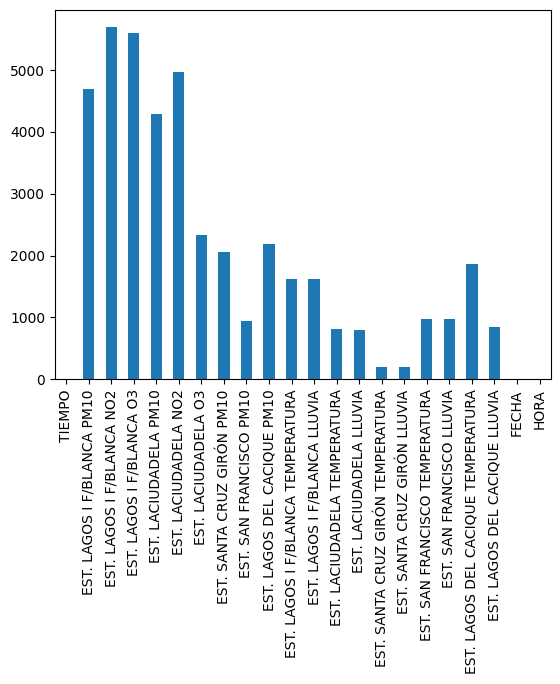

In [179]:
df_normalizado.isnull().sum().plot(kind="bar")

Como ya tratamos los nulos atípicos, podemos seguir con los nulos normales antes de abordar los outliers.

¿Por qué?
Los nulos normales son valores ausentes en condiciones esperadas (por ejemplo, una falla temporal del sensor o datos no registrados en ciertas horas).

Los outliers son valores extremos que pueden influir en la imputación de los nulos si los tratamos después.

Si tratamos primero los nulos normales, evitamos que los outliers sesguen la media o la mediana que usaremos para imputarlos.

<ipython-input-180-d81905be0562>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputado[sensor].fillna(media_winsorizada, inplace=True)


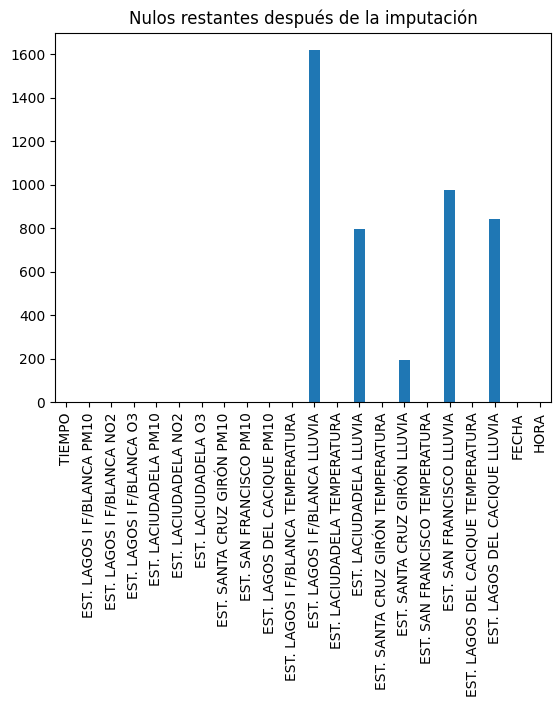

In [180]:
df_imputado = df_normalizado.copy()

# Identificamos las columnas de sensores (las que contienen "EST.")
columnas_sensores = [col for col in df_imputado.columns if "EST." in col]

for sensor in columnas_sensores:
    # Filtramos valores dentro del rango definido en rangos_sensores
    min_val, max_val = rangos_sensores.get(sensor, (None, None))

    if min_val is not None and max_val is not None:
        datos_validos = df_imputado[(df_imputado[sensor] >= min_val) &
                                    (df_imputado[sensor] <= max_val)][sensor].dropna()

        if not datos_validos.empty:
            # Aplicamos winsorización (5% en cada extremo)
            datos_winsorizados = winsorize(datos_validos, limits=(0.05, 0.05))

            # Calculamos la media winsorizada
            media_winsorizada = datos_winsorizados.mean()

            # Imputamos los nulos con la media winsorizada
            df_imputado[sensor].fillna(media_winsorizada, inplace=True)

# Verificar si aún hay nulos
df_imputado.isnull().sum().plot(kind="bar")
plt.title("Nulos restantes después de la imputación")
plt.show()



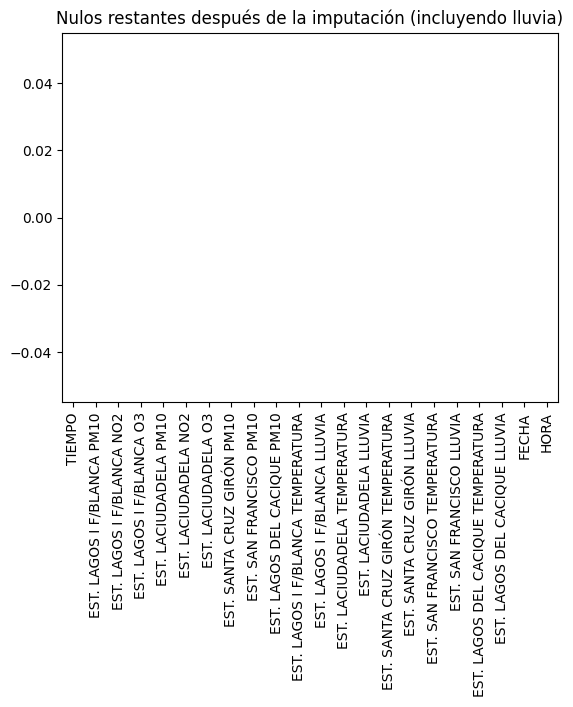

In [181]:
# Identificamos las columnas de lluvia
columnas_lluvia = [col for col in df_imputado.columns if "LLUVIA" in col]

# Imputamos los nulos con la mediana de cada columna
df_imputado[columnas_lluvia] = df_imputado[columnas_lluvia].apply(lambda col: col.fillna(col.median()))

# Verificar si aún hay nulos
df_imputado.isnull().sum().plot(kind="bar")
plt.title("Nulos restantes después de la imputación (incluyendo lluvia)")
plt.show()


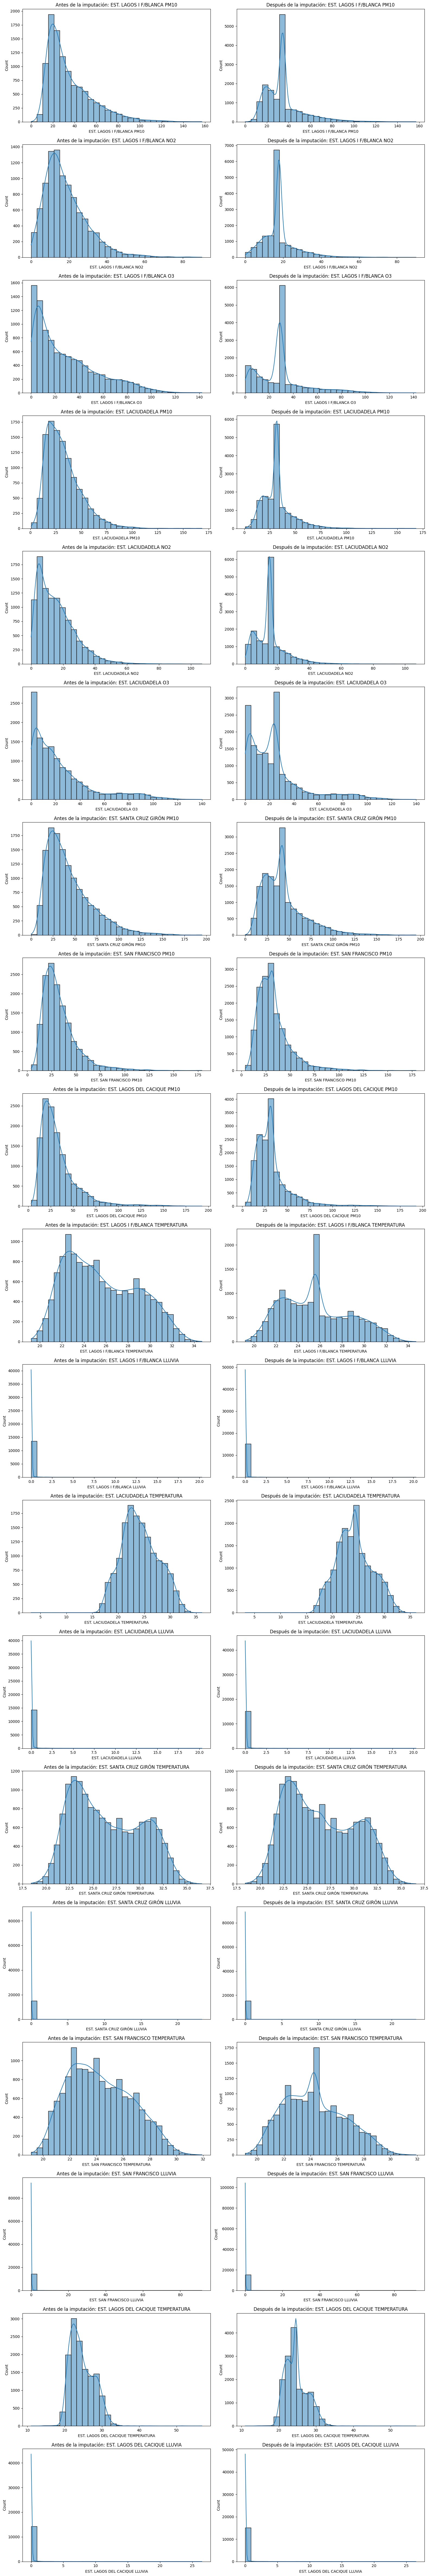

In [182]:
# Crear gráficos antes y después de la imputación de nulos normales
fig, axes = plt.subplots(len(columnas_sensores), 2, figsize=(16, 5 * len(columnas_sensores)))

for i, col in enumerate(columnas_sensores):
    # Gráfico antes de la imputación
    sns.histplot(df_normalizado[col], kde=True, bins=30, ax=axes[i, 0])
    axes[i, 0].set_title(f"Antes de la imputación: {col}")

    # Gráfico después de la imputación
    sns.histplot(df_imputado[col], kde=True, bins=30, ax=axes[i, 1])
    axes[i, 1].set_title(f"Después de la imputación: {col}")

plt.tight_layout()
plt.show()

## Tratamiento de Outliers
Hasta ahora, hemos manejado los valores nulos en nuestros datos, tanto los atípicos como los normales. Ahora, nos enfocaremos en los outliers, que son valores que se salen de los rangos definidos como normales para cada sensor.

Estos valores pueden aparecer por fallos en los sensores, errores en la captura de datos o incluso eventos ambientales inusuales. Como nuestro objetivo es mejorar la calidad de los datos sin distorsionar patrones reales, aplicaremos técnicas de detección y ajuste que permitan corregir estos valores sin perder información valiosa.

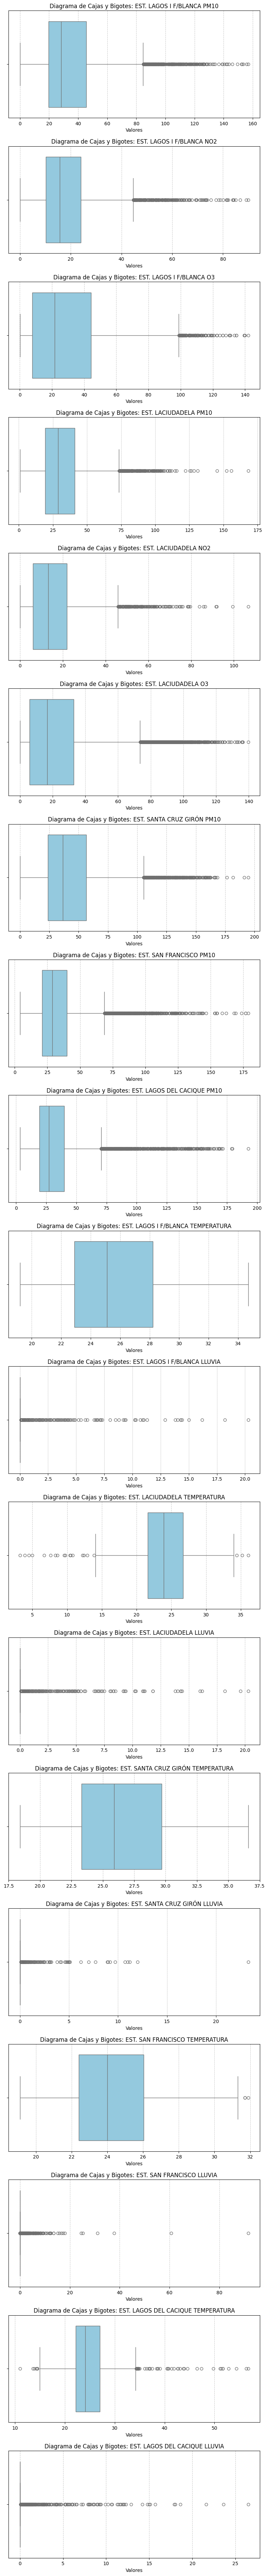

In [183]:
# Seleccionar solo las columnas de sensores
sensores_cols = [col for col in df_imputado.columns if col not in ["FECHA", "HORA", "TIEMPO"]]

# Crear gráficos individuales
fig, axes = plt.subplots(len(sensores_cols), 1, figsize=(8, 4 * len(sensores_cols)))

for i, col in enumerate(sensores_cols):
    sns.boxplot(x=df_ajustado[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Diagrama de Cajas y Bigotes: {col}")
    axes[i].set_xlabel("Valores")
    axes[i].grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [184]:
# Calcular Q1 (percentil 25) y Q3 (percentil 75) para cada sensor
q1 = df_imputado[sensores_cols].quantile(0.25)
q3 = df_imputado[sensores_cols].quantile(0.75)
iqr = q3 - q1  # Rango intercuartílico

# Definir límites para valores atípicos
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Contar cuántos valores están fuera de esos límites (atípicos)
valores_atipicos = ((df_ajustado[sensores_cols] < limite_inferior) |
                     (df_ajustado[sensores_cols] > limite_superior)).sum()

# Mostrar cuántos valores atípicos tiene cada sensor
print("Cantidad de valores atípicos por sensor:")
print(valores_atipicos)


Cantidad de valores atípicos por sensor:
EST. LAGOS I F/BLANCA PM10            1652
EST. LAGOS I F/BLANCA NO2             2569
EST. LAGOS I F/BLANCA O3              1717
EST. LACIUDADELA PM10                 1207
EST. LACIUDADELA NO2                  1237
EST. LACIUDADELA O3                   1358
EST. SANTA CRUZ GIRÓN PM10             765
EST. SAN FRANCISCO PM10                772
EST. LAGOS DEL CACIQUE PM10           1178
EST. LAGOS I F/BLANCA TEMPERATURA        0
EST. LAGOS I F/BLANCA LLUVIA           526
EST. LACIUDADELA TEMPERATURA            27
EST. LACIUDADELA LLUVIA                806
EST. SANTA CRUZ GIRÓN TEMPERATURA        0
EST. SANTA CRUZ GIRÓN LLUVIA           301
EST. SAN FRANCISCO TEMPERATURA          10
EST. SAN FRANCISCO LLUVIA             1092
EST. LAGOS DEL CACIQUE TEMPERATURA     115
EST. LAGOS DEL CACIQUE LLUVIA          815
dtype: int64


In [185]:
df_discreto = df_imputado.copy()
# Identificar todas las columnas que contienen "LLUVIA"
columnas_lluvia = [col for col in df_discreto.columns if "LLUVIA" in col]

# Definir el número de clusters
n_clusters = 4

# Diccionario para almacenar los modelos K-Means
modelos_kmeans = {}

for col in columnas_lluvia:
    lluvia_values = df_discreto[[col]].copy()  # Extraer la columna

    # Verificar si hay valores NaN
    if lluvia_values.isna().sum().sum() > 0:
        print(f"⚠️ Se encontraron NaN en {col}. Se reemplazarán con la mediana.")
        lluvia_values.fillna(lluvia_values.median(), inplace=True)

    # Aplicar K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(lluvia_values)

    # Guardar el modelo en el diccionario
    modelos_kmeans[col] = kmeans

    # Asignar los clusters al DataFrame
    df_discreto[f"{col}_cluster"] = clusters

# Guardar el modelo en un archivo .pkl
with open("kmeans_lluvia.pkl", "wb") as archivo:
    pickle.dump(modelos_kmeans, archivo)

# Imprimir información general sobre la clusterización
print("📌 Se ha aplicado K-Means para discretizar las columnas de lluvia en", n_clusters, "categorías.")
print("💾 Modelos de clusterización guardados en 'kmeans_lluvia.pkl'.")

for col in columnas_lluvia:
    print(f"📊 En {col}:")
    print(df_discreto[f"{col}_cluster"].value_counts().sort_index())
    print("-" * 50)



📌 Se ha aplicado K-Means para discretizar las columnas de lluvia en 4 categorías.
💾 Modelos de clusterización guardados en 'kmeans_lluvia.pkl'.
📊 En EST. LAGOS I F/BLANCA LLUVIA:
EST. LAGOS I F/BLANCA LLUVIA_cluster
0    15271
1       24
2       87
3       10
Name: count, dtype: int64
--------------------------------------------------
📊 En EST. LACIUDADELA LLUVIA:
EST. LACIUDADELA LLUVIA_cluster
0    15221
1       28
2      133
3       10
Name: count, dtype: int64
--------------------------------------------------
📊 En EST. SANTA CRUZ GIRÓN LLUVIA:
EST. SANTA CRUZ GIRÓN LLUVIA_cluster
0    15340
1       41
2        1
3       10
Name: count, dtype: int64
--------------------------------------------------
📊 En EST. SAN FRANCISCO LLUVIA:
EST. SAN FRANCISCO LLUVIA_cluster
0    15304
1        2
2        9
3       77
Name: count, dtype: int64
--------------------------------------------------
📊 En EST. LAGOS DEL CACIQUE LLUVIA:
EST. LAGOS DEL CACIQUE LLUVIA_cluster
0    15233
1       11
2   

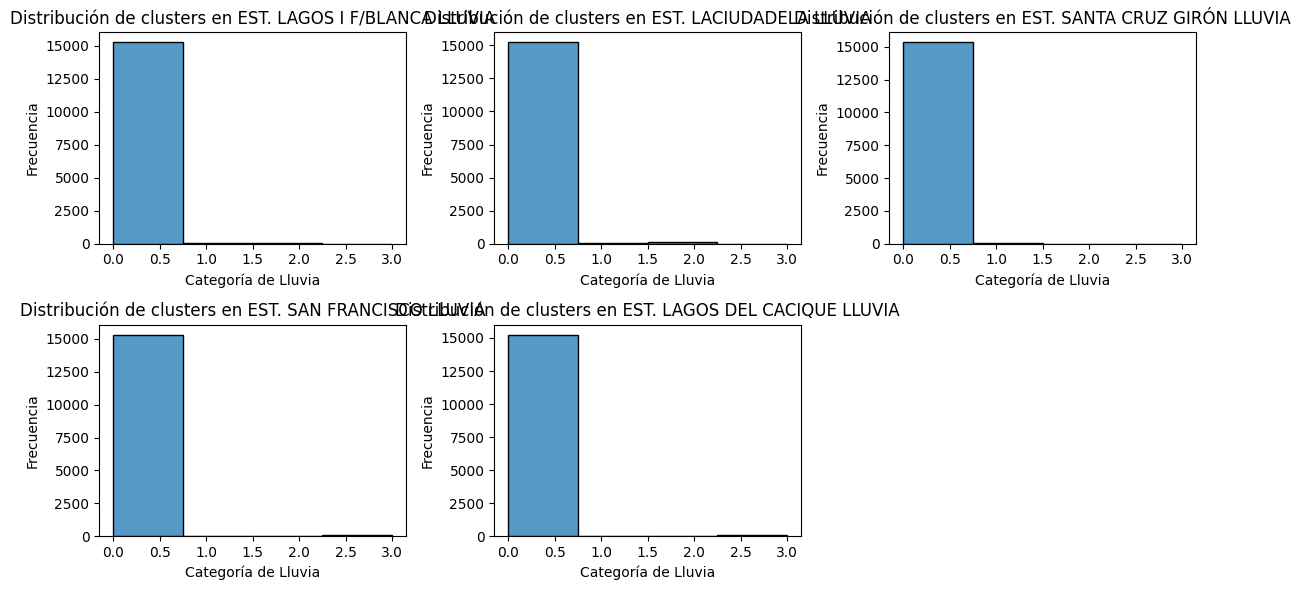

In [186]:

# Configuración del gráfico
plt.figure(figsize=(12, 6))

for i, col in enumerate(columnas_lluvia):
    plt.subplot(2, len(columnas_lluvia) // 2 + 1, i + 1)  # Subgráficos dinámicos
    sns.histplot(df_discreto[f"{col}_cluster"], bins=n_clusters, kde=False)
    plt.title(f"Distribución de clusters en {col}")
    plt.xlabel("Categoría de Lluvia")
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

 Código para Ajustar Sensores Fuera de Rango con Mediana y Media Recortada
Este código revisará cada sensor según los límites definidos en rangos_sensores.

📌 Reglas de ajuste:
1️⃣ Si el valor está levemente fuera del rango, se reemplaza con la mediana de la columna.
2️⃣ Si el valor es extremadamente atípico, se usará la media recortada (trimming), eliminando un 10% de valores extremos antes de calcularla.

In [187]:
# Crear una copia del dataframe para trabajar sobre él
df_sensores_ajustado = df_discreto.copy()

# Diccionario para almacenar la cantidad de valores ajustados
valores_ajustados = {}

for sensor, (min_val, max_val) in rangos_sensores.items():
    if sensor in df_sensores_ajustado.columns:
        valores_sensor = df_sensores_ajustado[sensor]

        # Calcular estadísticas
        mediana = valores_sensor.median()
        media_recortada = trim_mean(valores_sensor, proportiontocut=0.10)

        # Contadores de ajustes
        ajuste_mediana = ((valores_sensor < min_val) | (valores_sensor > max_val)).sum()
        ajuste_media_recortada = ((valores_sensor < min_val * 0.5) | (valores_sensor > max_val * 1.5)).sum()

        # Aplicar los ajustes en un solo paso
        df_sensores_ajustado[sensor] = valores_sensor.apply(lambda x:
            media_recortada if (x < min_val * 0.5 or x > max_val * 1.5) else
            (mediana if (x < min_val or x > max_val) else x)
        )

        # Guardar el resumen de ajustes
        valores_ajustados[sensor] = {
            "Reemplazados con Mediana": ajuste_mediana,
            "Reemplazados con Media Recortada": ajuste_media_recortada
        }

        # Imprimir detalles
        print(f"✅ Ajuste aplicado en {sensor}")
        print(f"📊 Rango esperado: {min_val} - {max_val}")
        print(f"📈 Mediana usada: {mediana:.2f} | 📉 Media recortada usada: {media_recortada:.2f}")
        print(f"🔹 {ajuste_mediana} valores ajustados con Mediana")
        print(f"🔹 {ajuste_media_recortada} valores ajustados con Media Recortada")
        print("-" * 50)

# Verificación general
print("📌 Ajustes completados en todas las columnas de sensores.")

# Convertir los ajustes a un DataFrame para su análisis
df_ajustes = pd.DataFrame.from_dict(valores_ajustados, orient="index")
print("📊 Resumen de valores ajustados:")
print(df_ajustes)


✅ Ajuste aplicado en EST. LAGOS I F/BLANCA TEMPERATURA
📊 Rango esperado: 18 - 44
📈 Mediana usada: 25.58 | 📉 Media recortada usada: 25.45
🔹 0 valores ajustados con Mediana
🔹 0 valores ajustados con Media Recortada
--------------------------------------------------
✅ Ajuste aplicado en EST. LACIUDADELA TEMPERATURA
📊 Rango esperado: 18 - 44
📈 Mediana usada: 24.10 | 📉 Media recortada usada: 24.13
🔹 370 valores ajustados con Mediana
🔹 3 valores ajustados con Media Recortada
--------------------------------------------------
✅ Ajuste aplicado en EST. SANTA CRUZ GIRÓN TEMPERATURA
📊 Rango esperado: 18 - 44
📈 Mediana usada: 25.90 | 📉 Media recortada usada: 26.33
🔹 0 valores ajustados con Mediana
🔹 0 valores ajustados con Media Recortada
--------------------------------------------------
✅ Ajuste aplicado en EST. SAN FRANCISCO TEMPERATURA
📊 Rango esperado: 18 - 44
📈 Mediana usada: 24.27 | 📉 Media recortada usada: 24.19
🔹 0 valores ajustados con Mediana
🔹 0 valores ajustados con Media Recortada
-

In [188]:
# Crear un diccionario para comparar valores atípicos antes y después del ajuste
comparacion_atipicos = {}

for sensor, valores_previos in valores_atipicos.items():
    # Verificar que el sensor esté en rangos_sensores
    if sensor in rangos_sensores:
        valores_nuevos = ((df_sensores_ajustado[sensor] < rangos_sensores[sensor][0]) |
                          (df_sensores_ajustado[sensor] > rangos_sensores[sensor][1])).sum()

        comparacion_atipicos[sensor] = {
            "Antes": valores_previos,
            "Después": valores_nuevos,
            "Reducción": valores_previos - valores_nuevos
        }

# Convertir a DataFrame para visualizar mejor
df_comparacion_atipicos = pd.DataFrame.from_dict(comparacion_atipicos, orient="index")

# Mostrar la comparación
print("📊 Comparación de valores atípicos antes y después del ajuste:")
print(df_comparacion_atipicos)


📊 Comparación de valores atípicos antes y después del ajuste:
                                    Antes  Después  Reducción
EST. LAGOS I F/BLANCA PM10           1652        0       1652
EST. LAGOS I F/BLANCA NO2            2569        0       2569
EST. LAGOS I F/BLANCA O3             1717        0       1717
EST. LACIUDADELA PM10                1207        0       1207
EST. LACIUDADELA NO2                 1237        0       1237
EST. LACIUDADELA O3                  1358        0       1358
EST. SANTA CRUZ GIRÓN PM10            765        0        765
EST. SAN FRANCISCO PM10               772        0        772
EST. LAGOS DEL CACIQUE PM10          1178        0       1178
EST. LAGOS I F/BLANCA TEMPERATURA       0        0          0
EST. LACIUDADELA TEMPERATURA           27        0         27
EST. SANTA CRUZ GIRÓN TEMPERATURA       0        0          0
EST. SAN FRANCISCO TEMPERATURA         10        0         10
EST. LAGOS DEL CACIQUE TEMPERATURA    115        0        115


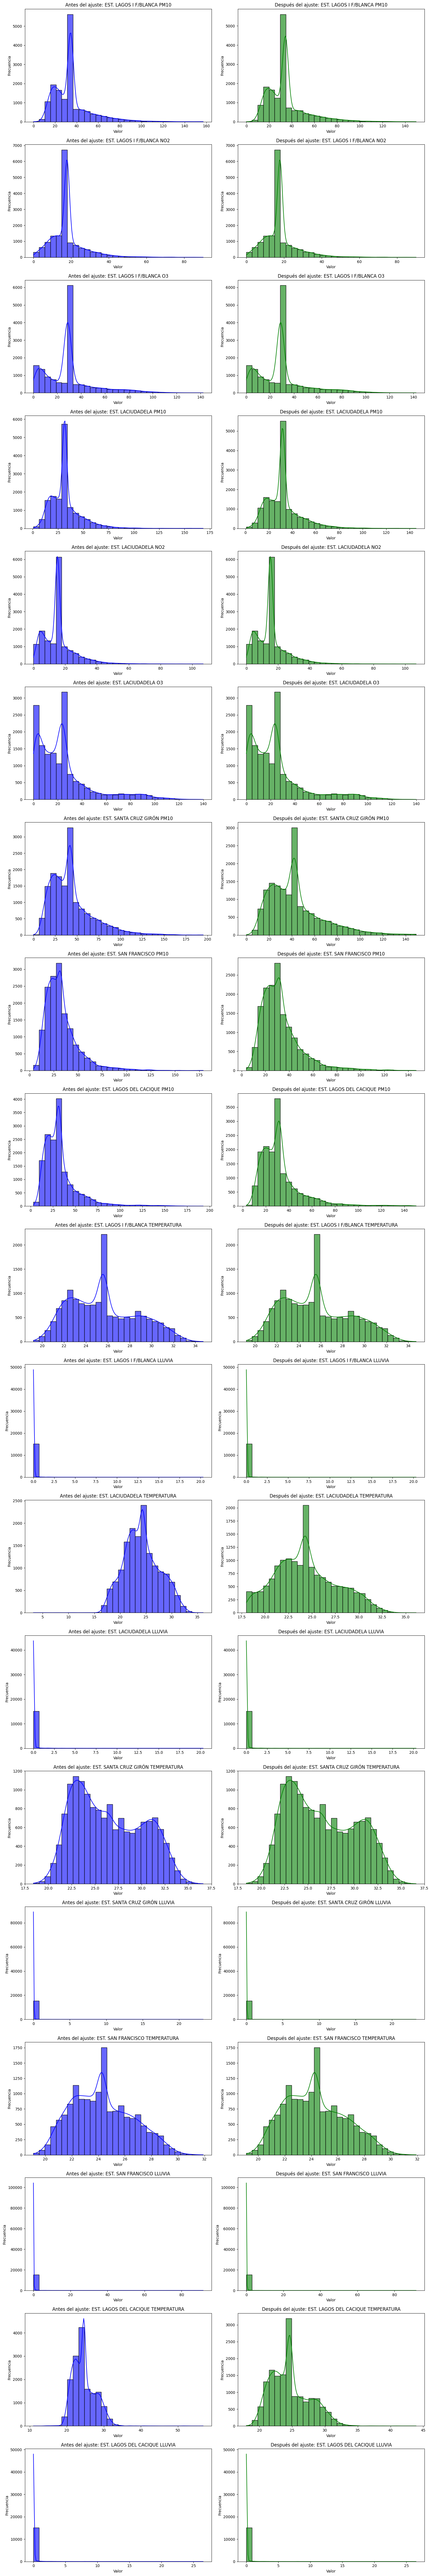

In [189]:

# Crear figura con subgráficos
fig, axes = plt.subplots(len(columnas_sensores), 2, figsize=(16, 5 * len(columnas_sensores)))

for i, col in enumerate(columnas_sensores):
    # Gráfico antes del ajuste (df_imputado)
    sns.histplot(df_imputado[col], kde=True, bins=30, ax=axes[i, 0], color='blue', alpha=0.6)
    axes[i, 0].set_title(f"Antes del ajuste: {col}")
    axes[i, 0].set_xlabel("Valor")
    axes[i, 0].set_ylabel("Frecuencia")

    # Gráfico después del ajuste (df_sensores_ajustado)
    sns.histplot(df_sensores_ajustado[col], kde=True, bins=30, ax=axes[i, 1], color='green', alpha=0.6)
    axes[i, 1].set_title(f"Después del ajuste: {col}")
    axes[i, 1].set_xlabel("Valor")
    axes[i, 1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [199]:
df_final = df_sensores_ajustado.copy()

# Modelo predictivo

En esta sección, construiremos modelos de Machine Learning para predecir tres variables clave relacionadas con la calidad del aire y el clima en la ciudad:

1️⃣ Temperatura: Buscamos predecir la temperatura en función de la hora del día, la presencia de lluvia y otros sensores ambientales relevantes.

2️⃣ Calidad del Aire (PM10): Modelaremos la concentración de material particulado PM10 utilizando como predictores la hora, los niveles de NO₂ y O₃, además de otras variables útiles.

3️⃣ Lluvia: Crearemos un modelo para determinar la probabilidad de lluvia basándonos en la hora y otros sensores disponibles.

Antes de construir los modelos, realizaremos un análisis exploratorio para identificar qué variables tienen mayor influencia en cada predicción. Esto incluirá un análisis de correlación para seleccionar las características más relevantes y evitar redundancias en los modelos.



In [243]:
#  Agrupar datos para hacer un modelo general de la ciudad
columnas_temperatura = [col for col in df_final.columns if "TEMPERATURA" in col]
columnas_pm10 = [col for col in df_final.columns if "PM10" in col]
columnas_no2 = [col for col in df_final.columns if "NO2" in col]
columnas_o3 = [col for col in df_final.columns if "O3" in col]
columnas_lluvia = [col for col in df_final.columns if "EST." and "LLUVIA" in col]  # Lluvia nominal

# Crear nuevas columnas con los promedios de la ciudad
df_final["TEMPERATURA_CIUDAD"] = df_final[columnas_temperatura].mean(axis=1)
df_final["PM10_CIUDAD"] = df_final[columnas_pm10].mean(axis=1)
df_final["NO2_CIUDAD"] = df_final[columnas_no2].mean(axis=1)
df_final["O3_CIUDAD"] = df_final[columnas_o3].mean(axis=1)
df_final["LLUVIA_CIUDAD"] = df_final[columnas_lluvia].mean(axis=1)  # Si la lluvia es discreta, el promedio sigue representativo

#  Resumen estadístico
print(" Resumen estadístico después de la agregación por ciudad:")
display(df_final[["TEMPERATURA_CIUDAD", "PM10_CIUDAD", "NO2_CIUDAD", "O3_CIUDAD", "LLUVIA_CIUDAD"]].describe())



 Resumen estadístico después de la agregación por ciudad:


TEMPERATURA_CIUDAD   PM10_CIUDAD    NO2_CIUDAD     O3_CIUDAD  \
count        15392.000000  15392.000000  15392.000000  15392.000000   
mean            25.076938     35.120406     16.774860     26.775354   
std              2.812211     15.519785      7.902058     20.455592   
min             19.200000      6.380000      0.000000      0.250000   
25%             22.772048     24.549739     12.004744     14.803463   
50%             24.644165     31.633018     16.498881     22.703463   
75%             27.300000     41.845156     19.212600     31.059575   
max             33.220000    128.400000     84.156600    139.650000   

       LLUVIA_CIUDAD  
count   15392.000000  
mean        0.038155  
std         0.292898  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         9.185124

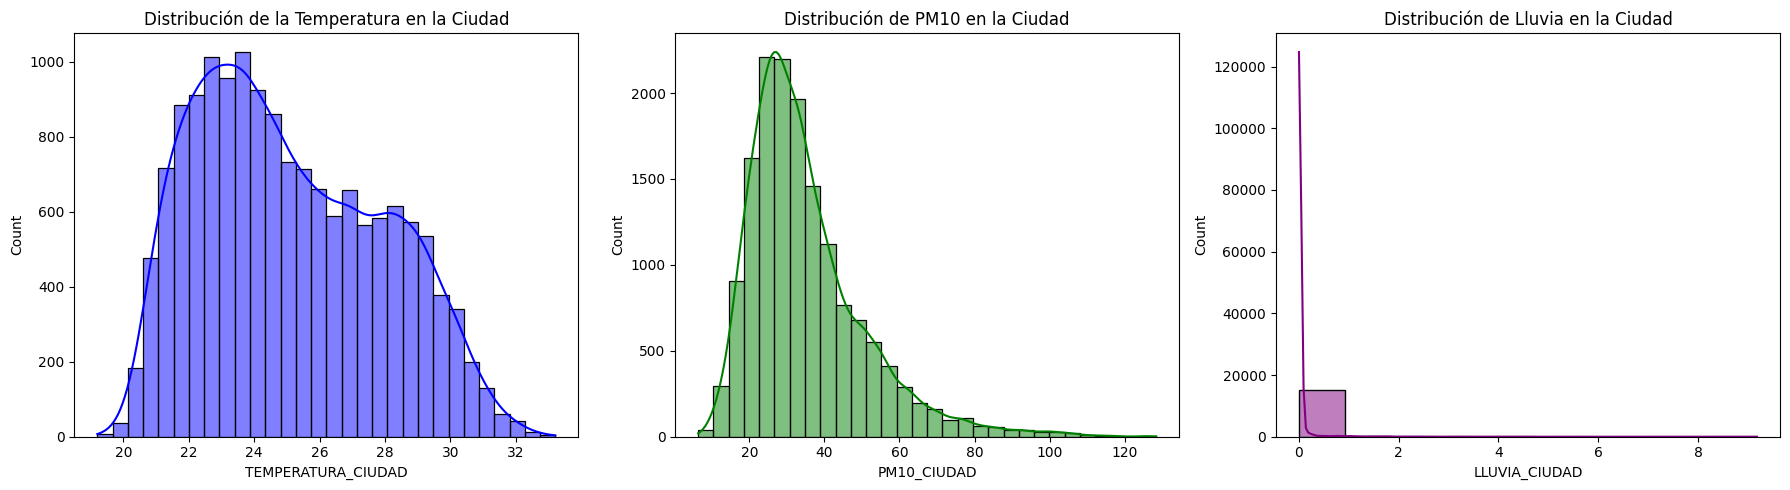

In [244]:
#  Distribución de las variables objetivo
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_final["TEMPERATURA_CIUDAD"], kde=True, bins=30, ax=axes[0], color="blue")
axes[0].set_title("Distribución de la Temperatura en la Ciudad")

sns.histplot(df_final["PM10_CIUDAD"], kde=True, bins=30, ax=axes[1], color="green")
axes[1].set_title("Distribución de PM10 en la Ciudad")

sns.histplot(df_final["LLUVIA_CIUDAD"], kde=True, bins=10, ax=axes[2], color="purple")
axes[2].set_title("Distribución de Lluvia en la Ciudad")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


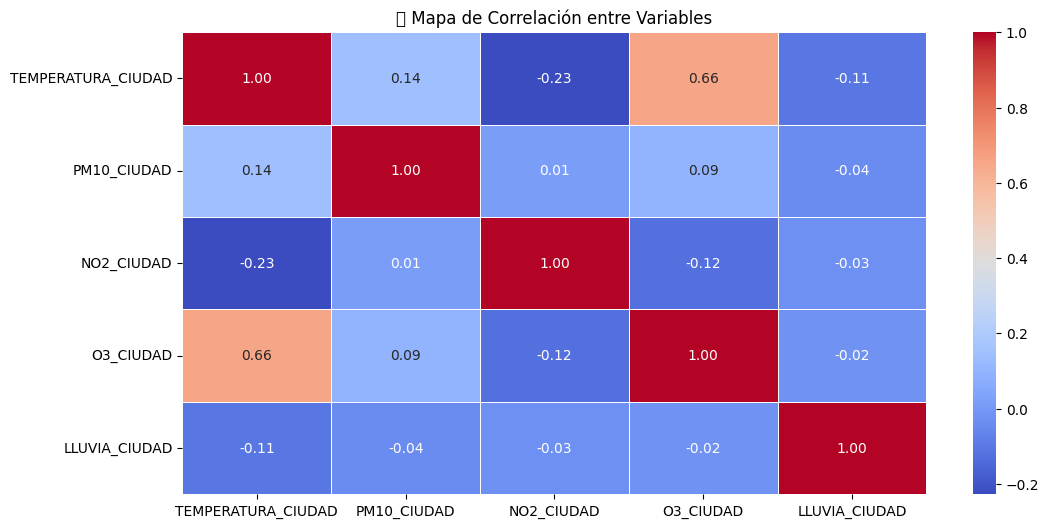

In [245]:
#  Matriz de correlación
plt.figure(figsize=(12, 6))
sns.heatmap(df_final[["TEMPERATURA_CIUDAD", "PM10_CIUDAD", "NO2_CIUDAD", "O3_CIUDAD", "LLUVIA_CIUDAD"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("🔍 Mapa de Correlación entre Variables")
plt.show()

Preparar los datos para el modelado:

Separar variables predictoras y objetivos.

Dividir en conjunto de entrenamiento y prueba.

Escalar si es necesario.

In [276]:
df_final["HORA"] = df_final["HORA"].str[:2].astype(int)
print(df_final["HORA"].unique())

AttributeError: Can only use .str accessor with string values!

In [248]:
#  Definir variables predictoras y objetivo para cada modelo
# Modelo de temperatura
X_temp = df_final[["HORA", "LLUVIA_CIUDAD", "NO2_CIUDAD", "O3_CIUDAD"]]
y_temp = df_final["TEMPERATURA_CIUDAD"]

# Modelo de calidad del aire (PM10)
X_pm10 = df_final[["HORA", "NO2_CIUDAD", "O3_CIUDAD", "TEMPERATURA_CIUDAD"]]
y_pm10 = df_final["PM10_CIUDAD"]


#  Dividir en entrenamiento (70%) y prueba (30%)
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(X_pm10, y_pm10, test_size=0.3, random_state=42)


print(" Datos preparados con un split 70-30 entre entrenamiento y prueba.")

 Datos preparados con un split 70-30 entre entrenamiento y prueba.


**Modelo Predictivo de Temperatura:**

El modelo buscará predecir la temperatura en la ciudad a partir de la hora, la lluvia y otros sensores disponibles. Se usará un Random Forest Regressor, un modelo de ensamble basado en múltiples árboles de decisión, adecuado para capturar relaciones no lineales en los datos.



In [249]:

# Definir el modelo
modelo_temp = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_temp.fit(X_train_temp, y_train_temp)

# Realizar predicciones
y_pred_temp = modelo_temp.predict(X_test_temp)

# Evaluación del modelo
mae_temp = mean_absolute_error(y_test_temp, y_pred_temp)
mse_temp = mean_squared_error(y_test_temp, y_pred_temp)
r2_temp = r2_score(y_test_temp, y_pred_temp)

# Mostrar resultados
print("Evaluación del Modelo de Temperatura:")
print(f"MAE: {mae_temp:.2f}")
print(f"MSE: {mse_temp:.2f}")
print(f"R²: {r2_temp:.2f}")

Evaluación del Modelo de Temperatura:
MAE: 0.96
MSE: 1.54
R²: 0.80


**Modelo Predictivo de PM10:**

El modelo buscará predecir la calidad del aire en la ciudad a partir de la hora, la lluvia y otros sensores disponibles. Se usará un Random Forest Regressor, un modelo de ensamble basado en múltiples árboles de decisión, adecuado para capturar relaciones no lineales en los datos.


In [250]:
# Definir y entrenar el modelo Random Forest
modelo_pm10 = RandomForestRegressor(n_estimators=200, random_state=45)
modelo_pm10.fit(X_train_pm10, y_train_pm10)

# Realizar predicciones
y_pred_pm10 = modelo_pm10.predict(X_test_pm10)

# Evaluar el modelo
mae_pm10 = mean_absolute_error(y_test_pm10, y_pred_pm10)
mse_pm10 = mean_squared_error(y_test_pm10, y_pred_pm10)
r2_pm10 = r2_score(y_test_pm10, y_pred_pm10)

# Mostrar métricas de evaluación
print(f"Evaluación del Modelo de PM10 (Random Forest):")
print(f"MAE: {mae_pm10:.2f}")
print(f"MSE: {mse_pm10:.2f}")
print(f"R²: {r2_pm10:.2f}")


Evaluación del Modelo de PM10 (Random Forest):
MAE: 8.69
MSE: 154.76
R²: 0.36


Se probaron varios modelos de Machine Learning para predecir los niveles de PM10 en la ciudad. Inicialmente, se implementó un Random Forest Regressor, el cual obtuvo un
𝑅
2
R
2
  de 0.35, explicando aproximadamente el 35% de la variabilidad en los datos.

Posteriormente, se probaron otros enfoques como Regresión Lineal, que mostró un desempeño significativamente menor (
𝑅
2
R
2
  de 0.02), y Naive Bayes, que no fue adecuado debido a la naturaleza continua de la variable objetivo. También se exploró K-Nearest Neighbors (KNN), el cual mejoró los resultados tras normalizar los datos y ajustar el número de vecinos. Con KNN (k=15), se obtuvo un
𝑅
2
R
2
  de 0.34, con un MAE de 8.93 y un MSE de 159.23, lo que representa un rendimiento similar al de Random Forest.

Dado que Random Forest Regressor fue el modelo con mejor desempeño, se decidió utilizarlo como el modelo final para la predicción de PM10 en este proyecto.

Modelo predictivo lluvia:

In [273]:


# Seleccionar las variables predictoras (X) y la variable objetivo (y)
X_lluvia = df_final[["HORA", "TEMPERATURA_CIUDAD", "NO2_CIUDAD", "O3_CIUDAD", "PM10_CIUDAD"]]
y_lluvia = df_final["LLUVIA_CIUDAD"]  # LLUVIA_CIUDAD es la variable continua que vamos a clusterizar

# Aplicar K-Means para clusterizar la variable de lluvia
kmeans = KMeans(n_clusters=4, random_state=42)  # Ajusta n_clusters según lo que consideres necesario
df_final['LLUVIA_CLUSTER'] = kmeans.fit_predict(df_final[["TEMPERATURA_CIUDAD", "NO2_CIUDAD", "O3_CIUDAD", "PM10_CIUDAD"]])

# Ahora usa los clusters como etiquetas de clasificación
X_train, X_test, y_train, y_test = train_test_split(X_lluvia, df_final['LLUVIA_CLUSTER'], test_size=0.3, random_state=42)

# Modelo de clasificación (Random Forest o cualquier otro)
modelo_lluvia_regresion = RandomForestClassifier(n_estimators=200, random_state=45)
modelo_lluvia_regresion.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred = modelo.predict(X_test)

# Mostrar el reporte de clasificación
print("Evaluación del Modelo de Clasificación (Random Forest):")
print(classification_report(y_test, y_pred))



Evaluación del Modelo de Clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1660
           1       0.97      0.98      0.98      1801
           2       0.99      0.99      0.99       493
           3       0.97      0.98      0.97       664

    accuracy                           0.98      4618
   macro avg       0.98      0.98      0.98      4618
weighted avg       0.98      0.98      0.98      4618



Sesgo en el Modelo de Clasificación:

En el modelo de clasificación de lluvia, observamos que la moda de los datos está fuertemente inclinada hacia el valor 0, que representa la ausencia de lluvia (no lluvia). Este sesgo puede ocurrir debido a que la mayoría de los datos recolectados provienen de períodos sin lluvia, lo que genera una distribución desbalanceada de las clases en el conjunto de datos. En otras palabras, el modelo ha aprendido que la probabilidad de que no haya lluvia es mucho mayor que la de que sí haya lluvia, lo cual es común en muchas áreas donde las precipitaciones son eventos menos frecuentes.

Este sesgo puede afectar la capacidad del modelo para predecir correctamente los eventos de lluvia, ya que puede estar "sobreajustado" a la clase mayoritaria (no lluvia). Aunque el modelo puede alcanzar una precisión alta al predecir que no hay lluvia, es crucial mejorar la capacidad de detección de lluvias, especialmente en situaciones en las que el objetivo es predecir eventos de lluvia con mayor precisión.

In [275]:


# Guardar los modelos de regresión y clasificación
joblib.dump(modelo_temp, 'modelo_temperatura.pkl')
joblib.dump(modelo_pm10, 'modelo_pm10.pkl')
joblib.dump(modelo_lluvia_regresion, 'modelo_lluvia_cluster.pkl')

print("Modelos guardados correctamente.")



Modelos guardados correctamente.


In [277]:
from google.colab import files

# Descargar los modelos guardados
files.download('/content/modelo_temperatura.pkl')
files.download('/content/modelo_pm10.pkl')
files.download('/content/modelo_lluvia_cluster.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>